In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
data_path = './data'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root=data_path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# 2. Xây dựng mô hình CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
# 3. Khởi tạo mô hình, loss function và optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
# 4. Huấn luyện mô hình
epochs = 10  # Bạn có thể thay đổi số lượng epoch

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Huấn luyện trên dữ liệu train
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Đặt gradient về 0
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Tính toán gradient
        optimizer.step()  # Cập nhật weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Tính loss và accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Kiểm tra trên dữ liệu test
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():  # Không tính gradient khi test
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # In kết quả sau mỗi epoch
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/10
Train Loss: 0.1452, Train Accuracy: 95.57%
Test Loss: 0.0362, Test Accuracy: 98.76%
Epoch 2/10
Train Loss: 0.0443, Train Accuracy: 98.66%
Test Loss: 0.0429, Test Accuracy: 98.67%
Epoch 3/10
Train Loss: 0.0298, Train Accuracy: 99.07%
Test Loss: 0.0338, Test Accuracy: 98.88%
Epoch 4/10
Train Loss: 0.0228, Train Accuracy: 99.23%
Test Loss: 0.0312, Test Accuracy: 99.02%
Epoch 5/10
Train Loss: 0.0184, Train Accuracy: 99.40%
Test Loss: 0.0243, Test Accuracy: 99.20%
Epoch 6/10
Train Loss: 0.0119, Train Accuracy: 99.59%
Test Loss: 0.0340, Test Accuracy: 98.94%
Epoch 7/10
Train Loss: 0.0127, Train Accuracy: 99.57%
Test Loss: 0.0416, Test Accuracy: 99.00%
Epoch 8/10
Train Loss: 0.0112, Train Accuracy: 99.64%
Test Loss: 0.0276, Test Accuracy: 99.19%
Epoch 9/10
Train Loss: 0.0073, Train Accuracy: 99.77%
Test Loss: 0.0352, Test Accuracy: 99.04%
Epoch 10/10
Train Loss: 0.0075, Train Accuracy: 99.75%
Test Loss: 0.0293, Test Accuracy: 99.17%


In [11]:
# 5. Lưu mô hình sau khi huấn luyện
torch.save(model.state_dict(), 'handwriting_model.pth')

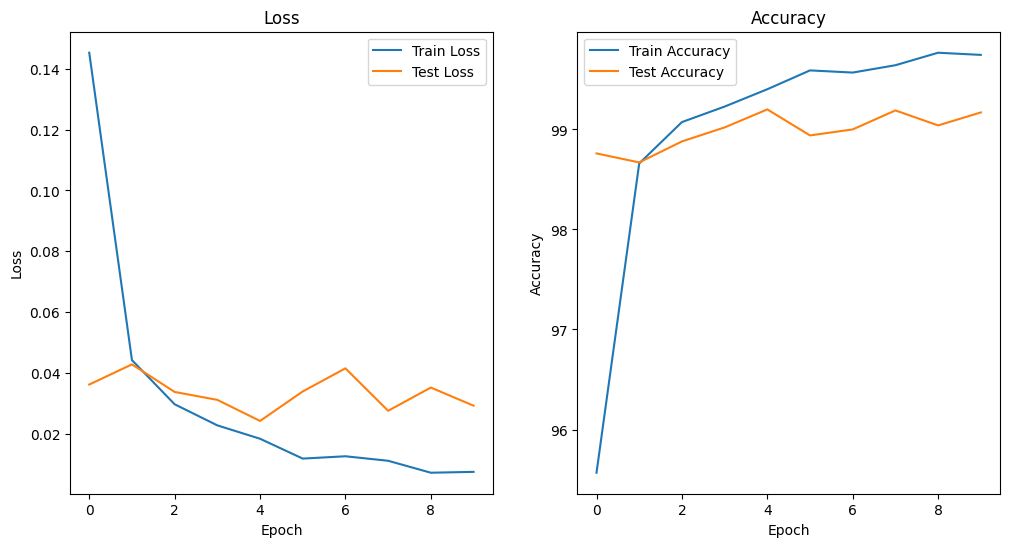

In [13]:
# 6. Vẽ đồ thị loss và accuracy
epochs_range = range(epochs)
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [1]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Chuyển ảnh RGB sang Grayscale
def preprocess_image(image_path):
    try:
        # Đảm bảo đường dẫn ảnh chính xác
        image = Image.open(image_path).convert('L')  # Chuyển sang grayscale (1 channel)
    except Exception as e:
        print(f"Lỗi khi mở ảnh: {e}")
        return None

    transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize ảnh về kích thước 28x28 (như MNIST)
    transforms.Grayscale(num_output_channels=1),  # Đảm bảo ảnh là grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: 1 - x)  # Đảo ngược màu sắc: trắng thành đen và ngược lại
])
    image = transform(image).unsqueeze(0)  # Thêm batch dimension
    return image

# Hàm dự đoán một ảnh
def predict(image_path):
    image = preprocess_image(image_path)
    
    if image is None:
        return "Không thể mở ảnh"
    
    # Đảm bảo mô hình đã được tải
    model.eval()
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    return predicted.item()

# Ví dụ sử dụng
image_path = r'debug_output.png'  # Đổi thành đường dẫn ảnh bạn muốn dự đoán
prediction = predict(image_path)
print(f"Dự đoán: {prediction}")


NameError: name 'model' is not defined